In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [49]:
from numpy import inf
from numpy import nan
import math
import itertools
import ProbGraphGenerator as pg
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt

In [358]:
from ipywidgets import *
from IPython.display import display
from ipywidgets import widgets

textPos = widgets.Text(description='List of Positive Arguments', width=500)
textNeg = widgets.Text(description='List of Negative Arguments', width=500)
display(textPos)
display(textNeg)

# list of user provided args
posArgs = []
negArgs = []

def handle_submit(sender):
    if sender == textPos:
        splitlist = (textPos.value).split(",")
        args = [int(a) for a in splitlist]
        posArgs.extend(args)
    if sender == textNeg:
        splitlist = (textNeg.value).split(",")
        args = [int(a) for a in splitlist]
        negArgs.extend(args)
        
    print(posArgs)
    print(negArgs)

    
textPos.on_submit(handle_submit)
textNeg.on_submit(handle_submit)



[0, 1]
[]
[0, 1]
[2]


<h1>Aggregation Approaches</h1>

In [411]:
allAgents = []

textAgent = widgets.Text(description='Insert an Agent', width=500)
display(textAgent)



def handle_new_agent(sender):
    
    splitlist = (textAgent.value).split(",")
    agentArgs = [int(a) for a in splitlist[0:-1]]
    agentTotals = []
    posFound = list(set(agentArgs).intersection(posArgs))
    negFound = list(set(agentArgs).intersection(negArgs))
    polarity = splitlist[-1]
    print(posFound, negFound, polarity)
    agentTotals = (posFound,negFound, polarity)
    
    allAgents.append(agentTotals)
    
textAgent.on_submit(handle_new_agent)

[0, 1] [2] +
[0, 1] [2] +
[0, 1] [2] +
[0] [2] +
[0] [2] +
[0] [2] +
[0] [] +
[0] [] +
[0] [] +


In [412]:
%%capture

graphDistribs = [] # Not needed when we have the graphDistribsGlobal
everyGraphProduced = np.unique(pg.generateGraphsGivenSetsOfArgs(posArgs, negArgs), axis=0)
everyGraphProduced = pg.arrangeEveryGragph(everyGraphProduced)


graphDistribsGlobal = []
probDistribs = []
argumentsInAgents = []
polarities = []
agentsStringified = []

for agent in allAgents:
    graphDistribsGlobalAgents = []
    everyGraphProducedAgent = []
    agPosArgs = agent[0]
    agNegArgs = agent[1]
    polarity = agent[2]
    
    argumentsInAgents.append([agPosArgs + agNegArgs])
    polarities.append(polarity)
    
    agentsStringified.append(str(agent))
    
    # generate the plausible graphs for this agent
    posArgsIdx = list(range(0,len(agPosArgs)))
    negArgsIdx = list(range(len(agPosArgs), len(agPosArgs)+len(agNegArgs)))
    x,y = pg.calculateProbabilityDistribution(posArgsIdx, negArgsIdx, polarity)
    
    # Generate an initial probability distribution for these graphs
    initialProbDist = [1/len(x)] * len(x)
    graphDistribs.append(x)
    probDistribs.append(initialProbDist)
    
    # Convert the graphs into a global contribution, needed so that we can compare different agents of different sizes
    noArgTypes = len(posArgs) + len(negArgs)
    
    
    allAttacks = list(itertools.product(list(agPosArgs+agNegArgs), repeat=2))
    allAttacksIdx = []
    for attack in allAttacks:
        ptn = ((attack[0]+1)*noArgTypes)- ((noArgTypes+1) - attack[1])+1
        allAttacksIdx.append(ptn)
    
    for g in x:
        #globalContribution = np.zeros(noArgTypes*noArgTypes)
        globalContribution = np.full((noArgTypes*noArgTypes), np.inf)
        globalContribution[allAttacksIdx] = g
        graphDistribsGlobalAgents.append(globalContribution)
    
    graphDistribsGlobal.append(graphDistribsGlobalAgents)
    
    for g in y:
        #globalContribution = np.zeros(noArgTypes*noArgTypes)
        globalContribution = np.full((noArgTypes*noArgTypes), np.inf)
        globalContribution[allAttacksIdx] = g
    


In [413]:
############################################### Approach 1 ####################################################################

allProbDistribs = np.zeros((len(everyGraphProduced),len(graphDistribsGlobal)))

for agentIdx, agentGraphs in enumerate(graphDistribsGlobal):
    
    probDistrib = [0]*len(everyGraphProduced)
    
    for graph in agentGraphs:
        i = (np.where((everyGraphProduced == graph).all(axis=1)))[0][0]
        allProbDistribs[i,agentIdx] = 1


In [414]:
############################################### Approach 2 ####################################################################

def checkBiDirAttacks(graph):
    
    argsList = range(0,int((math.sqrt(len(graph)))))
    dualLocations =  list(itertools.combinations(argsList, 2))
    
    for loc in dualLocations:

        noOfArgs = int(math.sqrt(len(graph)))
        pos = (loc[0] * noOfArgs) + loc[1]
        counterPos = (loc[1] * noOfArgs) + loc[0]
            
        net = graph[pos] + graph[counterPos]
        
        if net == 2:
            graph[pos] = 2
            graph[counterPos] = 2
        
    
    return graph

In [415]:
%%capture
allProbDistribs2 = np.zeros((len(everyGraphProduced),len(graphDistribsGlobal)))

pnts = range(0, int(math.sqrt(len(everyGraphProduced[0]))))
dualLocations = list(itertools.combinations(pnts, 2))

for agentIdx, agentGraphs in enumerate(graphDistribsGlobal):
    
    probDistrib = [0]*len(everyGraphProduced)
    
    print('changing agent-----*******')
    
    for graph in agentGraphs:

        for everyIdx, g in enumerate(everyGraphProduced):
            
            ginfs = np.sum(g == inf)
            agentinfs = np.sum(graph == inf)
            
            # If the agent is same than he can enrich
            if agentinfs == ginfs:
                i = (np.where((everyGraphProduced == graph).all(axis=1)))[0][0]
                allProbDistribs2[i,agentIdx] = 1
            
            # If the agent is smaller than he can enrich
            if agentinfs > ginfs:
                
                x = checkBiDirAttacks(np.copy(graph))
                y = checkBiDirAttacks(np.copy(g))
                
                multiple = x * y
                np.isnan(multiple)
                multiple[np.isnan(multiple)] = inf
                multiple[np.where(multiple==4)] = multiple[np.where(multiple==4)] / 2
                
                print(y)
                print(graph)
                print('-----------------')
                enrich = np.array_equal(multiple, graph)
                if enrich:
                    print(enrich)
                    allProbDistribs2[everyIdx,agentIdx] = 1
                             

In [416]:
%%capture
############################################### Approach 3 ####################################################################



allProbDistribs3 = np.zeros((len(everyGraphProduced),len(graphDistribsGlobal)))

pnts = range(0, int(math.sqrt(len(everyGraphProduced[0]))))
dualLocations = list(itertools.combinations(pnts, 2))

for agentIdx, agentGraphs in enumerate(graphDistribsGlobal):
    
    probDistrib = [0]*len(everyGraphProduced)
    
    print('changing agent-----*******')
    
    for graph in agentGraphs:

        for everyIdx, g in enumerate(everyGraphProduced):
            print(everyIdx, g)
            
            ginfs = np.sum(g == inf)
            agentinfs = np.sum(graph == inf)
            
            # If the agent is same than he can enrich
            if agentinfs == ginfs:
                i = (np.where((everyGraphProduced == graph).all(axis=1)))[0][0]
                print(i)
                allProbDistribs3[i,agentIdx] = 1
            
            # If the agent is larger than he can enrich
            if agentinfs < ginfs:
                
                x = checkBiDirAttacks(np.copy(graph))
                y = checkBiDirAttacks(np.copy(g))
                
                multiple = x * y
                np.isnan(multiple)
                multiple[np.isnan(multiple)] = inf
                multiple[np.where(multiple==4)] = multiple[np.where(multiple==4)] / 2
                
                print(y)
                print(graph)
                print('-----------------')
                enrich = np.array_equal(multiple, y)
                polarityMatch = (polarities[agentIdx] == pg.getGraphPolarityMixedGraphSize(g, posArgs, negArgs))
                if enrich and polarityMatch:
                    print(enrich)
                    allProbDistribs3[everyIdx,agentIdx] = 1
                
print(allProbDistribs3)     

In [417]:
%%capture
############################################### Approach 4 ####################################################################



allProbDistribs4 = np.zeros((len(everyGraphProduced),len(graphDistribsGlobal)))

pnts = range(0, int(math.sqrt(len(everyGraphProduced[0]))))
dualLocations = list(itertools.combinations(pnts, 2))

for agentIdx, agentGraphs in enumerate(graphDistribsGlobal):
    
    probDistrib = [0]*len(everyGraphProduced)
    
    print('changing agent-----*******')
    
    for graph in agentGraphs:

        for everyIdx, g in enumerate(everyGraphProduced):
            
            ginfs = np.sum(g == inf)
            agentinfs = np.sum(graph == inf)
            
            # If the agent is same than he can enrich
            if agentinfs == ginfs:
                i = (np.where((everyGraphProduced == graph).all(axis=1)))[0][0]
                allProbDistribs4[i,agentIdx] = 1
            
            # If the agent is smaller than he can enrich
            if agentinfs > ginfs:
                
                x = checkBiDirAttacks(np.copy(graph))
                y = checkBiDirAttacks(np.copy(g))
                
                multiple = x * y
                np.isnan(multiple)
                multiple[np.isnan(multiple)] = inf
                multiple[np.where(multiple==4)] = multiple[np.where(multiple==4)] / 2
                
                print(y)
                print(graph)
                print('------smaller agent------')
                enrich = np.array_equal(multiple, graph)
                if enrich:
                    print(enrich)
                    allProbDistribs4[everyIdx,agentIdx] = 1
            
            # If the agent is larger than he can enrich
            if agentinfs < ginfs:
                
                x = checkBiDirAttacks(np.copy(graph))
                y = checkBiDirAttacks(np.copy(g))
                
                multiple = x * y
                np.isnan(multiple)
                multiple[np.isnan(multiple)] = inf
                multiple[np.where(multiple==4)] = multiple[np.where(multiple==4)] / 2
                
                print(y)
                print(graph)
                print('------larger agent-------')
                enrich = np.array_equal(multiple, y)
                polarityMatch = (polarities[agentIdx] == pg.getGraphPolarityMixedGraphSize(g, posArgs, negArgs))
                if enrich and polarityMatch:
                    print(enrich)
                    allProbDistribs4[everyIdx,agentIdx] = 1
                
print(allProbDistribs4)     

In [418]:
%%capture
############################################### Approach 5 ####################################################################



allProbDistribs5 = np.zeros((len(everyGraphProduced),len(graphDistribsGlobal)))

pnts = range(0, int(math.sqrt(len(everyGraphProduced[0]))))
dualLocations = list(itertools.combinations(pnts, 2))

for agentIdx, agentGraphs in enumerate(graphDistribsGlobal):
    
    probDistrib = [0]*len(everyGraphProduced)
    
    print('changing agent-----*******')
    
    for graph in agentGraphs:

        for everyIdx, g in enumerate(everyGraphProduced):
            
            ginfs = np.sum(g == inf)
            agentinfs = np.sum(graph == inf)
            
            # If the agent is smaller than he can enrich
            # we will check to see if the graph comparing too is the largest graph
            if ginfs == 0:
                
                x = checkBiDirAttacks(np.copy(graph))
                y = checkBiDirAttacks(np.copy(g))
                
                multiple = x * y
                np.isnan(multiple)
                multiple[np.isnan(multiple)] = inf
                multiple[np.where(multiple==4)] = multiple[np.where(multiple==4)] / 2
                
                print(y)
                print(graph)
                print('-----------------')
                enrich = np.array_equal(multiple, graph)
                if enrich:
                    print(enrich)
                    allProbDistribs5[everyIdx,agentIdx] = 1
                
print(allProbDistribs5)     

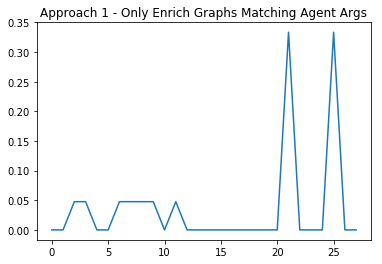

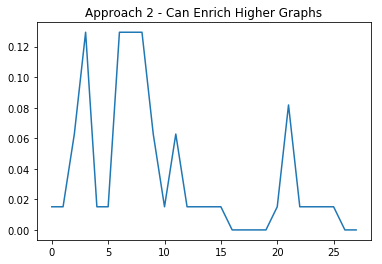

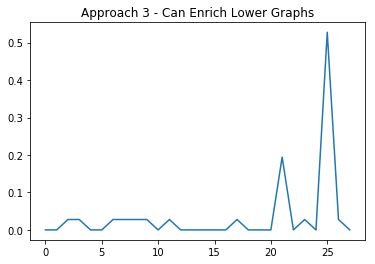

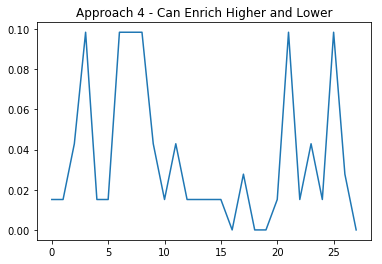

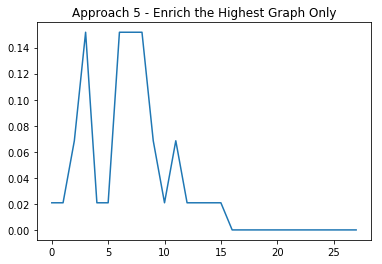

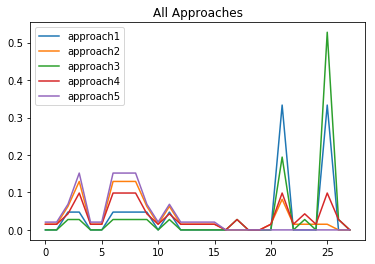

In [419]:
############################################### All Plots ####################################################################
sumallProbDistribs = allProbDistribs / (allProbDistribs != 0).sum(0)
sumallProbDistribs2 = allProbDistribs2 / (allProbDistribs2 != 0).sum(0)
sumallProbDistribs3 = allProbDistribs3 / (allProbDistribs3 != 0).sum(0)
sumallProbDistribs4 = allProbDistribs4 / (allProbDistribs4 != 0).sum(0)
sumallProbDistribs5 = allProbDistribs5 / (allProbDistribs5 != 0).sum(0)


net = np.sum(sumallProbDistribs, axis=1) / len(allAgents)
net2 = np.sum(sumallProbDistribs2, axis=1) / len(allAgents)
net3 = np.sum(sumallProbDistribs3, axis=1) /  len(allAgents)
net4 = np.sum(sumallProbDistribs4, axis=1) / len(allAgents)
net5 = np.sum(sumallProbDistribs5, axis=1) / len(allAgents)


%matplotlib inline
import matplotlib
matplotlib.rcParams['backend'] = "Qt4Agg"
import pylab
import numpy as np


x = range(0,len(net))  # 100 evenly-spaced values from 0 to 50


pylab.plot(x, net)
pylab.title('Approach 1 - Only Enrich Graphs Matching Agent Args')
pylab.savefig('Fig1.png')
pylab.show()

pylab.plot(x, net2)
pylab.title('Approach 2 - Can Enrich Higher Graphs')
pylab.savefig('Fig2.png')
pylab.show()

pylab.plot(x, net3)
pylab.title('Approach 3 - Can Enrich Lower Graphs')
pylab.savefig('Fig3.png')
pylab.show()

pylab.plot(x, net4)
pylab.title('Approach 4 - Can Enrich Higher and Lower')
pylab.savefig('Fig4.png')
pylab.show()

pylab.plot(x, net5)
pylab.title('Approach 5 - Enrich the Highest Graph Only')
pylab.savefig('Fig5.png')
pylab.show()


pylab.plot(x, net, label='approach1')
pylab.plot(x, net2, label='approach2')
pylab.plot(x, net3, label='approach3')
pylab.plot(x, net4, label='approach4')
pylab.plot(x, net5, label='approach5')
pylab.title('All Approaches')
pylab.legend()
pylab.savefig('FigAll.png')
pylab.show()

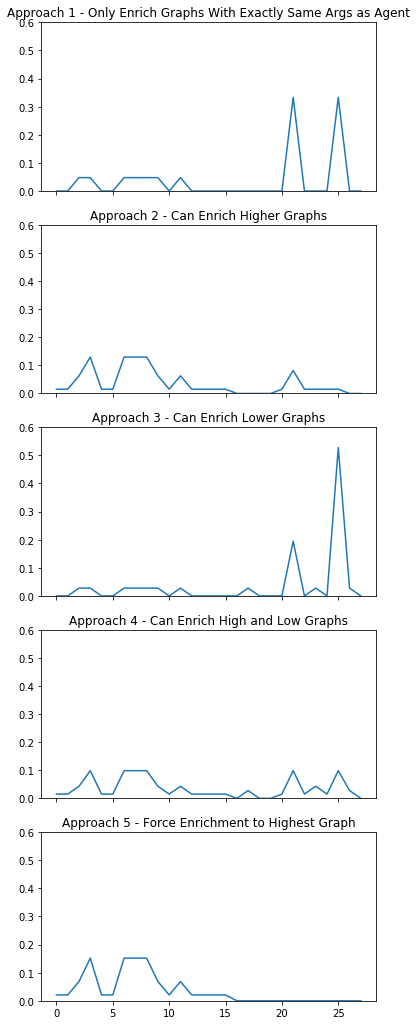

In [420]:



fig, axarr = plt.subplots(5, sharex=True)
fig.set_figheight(18)

axarr[0].plot(x, net)
axarr[0].set_ylim([0, 0.6])
axarr[0].set_title('Approach 1 - Only Enrich Graphs With Exactly Same Args as Agent')

axarr[1].plot(x, net2)
axarr[1].set_ylim([0, 0.6])
axarr[1].set_title('Approach 2 - Can Enrich Higher Graphs')
                   
axarr[2].plot(x, net3)
axarr[2].set_ylim([0, 0.6])
axarr[2].set_title('Approach 3 - Can Enrich Lower Graphs')


axarr[3].plot(x, net4)
axarr[3].set_ylim([0, 0.6])
axarr[3].set_title('Approach 4 - Can Enrich High and Low Graphs')

axarr[4].plot(x, net5)
axarr[4].set_ylim([0, 0.6])
axarr[4].set_title('Approach 5 - Force Enrichment to Highest Graph')



<h1>Query Approaches</h1>

In [421]:
textQueryAgent = widgets.Text(description='Insert Query Agent', width=500)
display(textQueryAgent)
# list of user provided args
queryAgent = []

def handle_submit(sender):
    splitlist = (textQueryAgent.value).split(",")
    args = [int(a) for a in splitlist]
    queryAgent.extend(args)
    print(queryAgent)
        
textQueryAgent.on_submit(handle_submit)



In [422]:
%%capture
from IPython.core.display import display, HTML
################################## Grounded Ext and Polarities Every Graph ######################################################

groundedExtensionsEveryGraph = []
print([groundedExtensionsEveryGraph.append(pg.getGroundedExtensionMixedGraphSize(thegraph, posArgs, negArgs)) for thegraph in everyGraphProduced])
allEveryGraphPols = []
for g in groundedExtensionsEveryGraph:
    if (list(g) == []):
        allEveryGraphPols.append('n')
        continue
    if (set(g) <= set(posArgs)):
        allEveryGraphPols.append('+')
        continue
    if (set(g) <=set(negArgs)):
        allEveryGraphPols.append('-')
        continue
    else:
        allEveryGraphPols.append(' ')

In [423]:
############################################### Query Approach 1 ################################################################


d = pd.DataFrame(np.zeros((4, 5)))
#d.set_index(['positiveChance','negativeChance', 'neutralChance', 'nothingChance'])
d.index = ['positiveChance','negativeChance', 'neutralChance', 'unknownChance']
d.columns = ['Apprch1','Apprch2', 'Apprch3', 'Apprch4', 'Apprch5']

queryAgent = [1]

groundedMatches = []

for i, groundedExtensionsEveryGraphSingle in enumerate(groundedExtensionsEveryGraph):
    
    match = set(groundedExtensionsEveryGraphSingle) == set(queryAgent)
    if match:
        groundedMatches.append(i)
        

        

In [424]:
allnets = [net, net2, net3, net4, net5]

for netNo, n in enumerate(allnets):
    groundedMatchesProbs = [n[i] for i in groundedMatches]
    groundedMatchesSigns = [allEveryGraphPols[i] for i in groundedMatches]
    
    positiveChance = 0
    negativeChance = 0
    neutralChance = 0
    nothingChance = 0

    for i, sign in enumerate(groundedMatchesSigns):
        if sign == '+':
            positiveChance += groundedMatchesProbs[i]
            continue
        if sign == '-':
            negativeChance += groundedMatchesProbs[i]
            continue
        if sign == 'n':
            neutralChance += groundedMatchesProbs[i]
            continue
        else:
            nothingChance += groundedMatchesProbs[i]
            continue
            
    d.iloc[:,netNo] = [positiveChance, negativeChance, neutralChance, nothingChance]

display(HTML('<h3>Query Approach 1</h3>'))
d

,Apprch1,Apprch2,Apprch3,Apprch4,Apprch5
positiveChance,0.0,0.015152,0.055556,0.070707,0.020833
negativeChance,0.0,0.000000,0.000000,0.000000,0.000000
neutralChance,0.0,0.000000,0.000000,0.000000,0.000000
unknownChance,0.0,0.000000,0.000000,0.000000,0.000000


In [425]:
%%capture
################################################ Query Approach 2 ################################################################


d = pd.DataFrame(np.zeros((4, 5)))
#d.set_index(['positiveChance','negativeChance', 'neutralChance', 'nothingChance'])
d.index = ['positiveChance','negativeChance', 'neutralChance', 'unknownChance']
d.columns = ['Apprch1','Apprch2', 'Apprch3', 'Apprch4', 'Apprch5']

queryAgent = [1]

groundedMatches = []

for i, groundedExtensionsEveryGraphSingle in enumerate(groundedExtensionsEveryGraph):
    match = set(queryAgent) <= set(groundedExtensionsEveryGraphSingle)
    print('q:', queryAgent, 'g:', groundedExtensionsEveryGraphSingle, ' ',match)
    if match:
        groundedMatches.append(i)
        
groundedMatches
groundedMatchesProbs = [n[i] for i in groundedMatches]
print(groundedMatchesProbs)

In [426]:
allnets = [net, net2, net3, net4, net5]

for netNo, n in enumerate(allnets):
    groundedMatchesProbs = [n[i] for i in groundedMatches]
    groundedMatchesSigns = [allEveryGraphPols[i] for i in groundedMatches]
    
    positiveChance = 0
    negativeChance = 0
    neutralChance = 0
    nothingChance = 0

    for i, sign in enumerate(groundedMatchesSigns):
        if sign == '+':
            positiveChance += groundedMatchesProbs[i]
            continue
        if sign == '-':
            negativeChance += groundedMatchesProbs[i]
            continue
        if sign == 'n':
            neutralChance += groundedMatchesProbs[i]
            continue
        else:
            nothingChance += groundedMatchesProbs[i]
            continue
            
    d.iloc[:,netNo] = [positiveChance, negativeChance, neutralChance, nothingChance]
    
display(HTML('<h3>Query Approach 2</h3>'))   
d

,Apprch1,Apprch2,Apprch3,Apprch4,Apprch5
positiveChance,0.333333,0.736364,0.277778,0.636364,0.833333
negativeChance,0.000000,0.000000,0.000000,0.000000,0.000000
neutralChance,0.000000,0.000000,0.000000,0.000000,0.000000
unknownChance,0.000000,0.030303,0.000000,0.030303,0.041667


In [427]:
%%capture
############################################### Query Approach 3 ################################################################

d = pd.DataFrame(np.zeros((4, 5)))
#d.set_index(['positiveChance','negativeChance', 'neutralChance', 'nothingChance'])
d.index = ['positiveChance','negativeChance', 'neutralChance', 'unknownChance']
d.columns = ['Apprch1','Apprch2', 'Apprch3', 'Apprch4', 'Apprch5']

queryAgent = [1]

groundedMatches = []

for i, groundedExtensionsEveryGraphSingle in enumerate(groundedExtensionsEveryGraph):
    
    match = set(groundedExtensionsEveryGraphSingle) <= set(queryAgent)
    if match:
        groundedMatches.append(i)

In [428]:
allnets = [net, net2, net3, net4, net5]

for netNo, n in enumerate(allnets):
    groundedMatchesProbs = [n[i] for i in groundedMatches]
    groundedMatchesSigns = [allEveryGraphPols[i] for i in groundedMatches]
    
    positiveChance = 0
    negativeChance = 0
    neutralChance = 0
    nothingChance = 0

    for i, sign in enumerate(groundedMatchesSigns):
        if sign == '+':
            positiveChance += groundedMatchesProbs[i]
            continue
        if sign == '-':
            negativeChance += groundedMatchesProbs[i]
            continue
        if sign == 'n':
            neutralChance += groundedMatchesProbs[i]
            continue
        else:
            nothingChance += groundedMatchesProbs[i]
            continue
            
    d.iloc[:,netNo] = [positiveChance, negativeChance, neutralChance, nothingChance]

display(HTML('<h3>Query Approach 3</h3>'))
d

,Apprch1,Apprch2,Apprch3,Apprch4,Apprch5
positiveChance,0.0,0.015152,0.055556,0.070707,0.020833
negativeChance,0.0,0.000000,0.000000,0.000000,0.000000
neutralChance,0.0,0.060606,0.000000,0.060606,0.062500
unknownChance,0.0,0.000000,0.000000,0.000000,0.000000


In [429]:
############################################### Query Approach 4 ################################################################

d = pd.DataFrame(np.zeros((4, 5)))
#d.set_index(['positiveChance','negativeChance', 'neutralChance', 'nothingChance'])
d.index = ['positiveChance','negativeChance', 'neutralChance', 'nothingChance']
d.columns = ['Apprch1','Apprch2', 'Apprch3', 'Apprch4', 'Apprch5']

queryAgent = [1]

groundedMatches = []

for i, groundedExtensionsEveryGraphSingle in enumerate(groundedExtensionsEveryGraph):
    
    match = set(groundedExtensionsEveryGraphSingle).intersection(queryAgent)
    if match:
        groundedMatches.append(i)
        

In [430]:
allnets = [net, net2, net3, net4, net5]

for netNo, n in enumerate(allnets):
    groundedMatchesProbs = [n[i] for i in groundedMatches]
    groundedMatchesSigns = [allEveryGraphPols[i] for i in groundedMatches]
    
    positiveChance = 0
    negativeChance = 0
    neutralChance = 0
    nothingChance = 0

    for i, sign in enumerate(groundedMatchesSigns):
        if sign == '+':
            positiveChance += groundedMatchesProbs[i]
            continue
        if sign == '-':
            negativeChance += groundedMatchesProbs[i]
            continue
        if sign == 'n':
            neutralChance += groundedMatchesProbs[i]
            continue
        else:
            nothingChance += groundedMatchesProbs[i]
            continue
            
    d.iloc[:,netNo] = [positiveChance, negativeChance, neutralChance, nothingChance]


In [431]:
display(HTML('<h3>Query Approach 4</h3>'))
d

,Apprch1,Apprch2,Apprch3,Apprch4,Apprch5
positiveChance,0.333333,0.736364,0.277778,0.636364,0.833333
negativeChance,0.000000,0.000000,0.000000,0.000000,0.000000
neutralChance,0.000000,0.000000,0.000000,0.000000,0.000000
nothingChance,0.000000,0.030303,0.000000,0.030303,0.041667


In [432]:
net

array([ 0.        ,  0.        ,  0.04761905,  0.04761905,  0.        ,
        0.        ,  0.04761905,  0.04761905,  0.04761905,  0.04761905,
        0.        ,  0.04761905,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.33333333,  0.        ,  0.        ,  0.        ,
        0.33333333,  0.        ,  0.        ])

In [433]:
everyGraphProduced

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   1.,   0.,   0.,   1.,   1.,   1.,   0.],
       [  0.,   0.,   1.,   0.,   0.,   1.,   1.,   0.,   0.],
       [  0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.],
       [  0.,   0.,   1.,   0.,   0.,   0.,   1.,   1.,   0.],
       [  0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.],
       [  0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.],
       [  0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   1.,   0.,   0.,   1.,   0.,   1.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   1.,   1.,   1.,

In [434]:
print(sumallProbDistribs)

[[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.14285714  0.14285714  0.14285714  0.          0.          0.          0.
   0.          0.        ]
 [ 0.14285714  0.14285714  0.14285714  0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.14285714  0.14285714  0.14285714  0.          0.          0.          0.
   0.          0.        ]
 [ 0.14285714  0.14285714  0.14285714  0.          0.          0.          0.
   0.          0.        ]
 [ 0.14285714  0.14285714  0.14285714  0.          0.          0.          0.
   0.          0.        ]
 [ 0.14285714  0.14285714  0.14285714  0.          0.  

In [435]:
np.sum(sumallProbDistribs5[:,-1])

1.0